In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import Series
from matplotlib import pyplot

%matplotlib inline 

In [2]:
#SETTING THE DATASET READY
data = pd.read_csv('../Battle-sensors/FINAL.csv', sep=',', parse_dates = ["record_date"])

C:\Users\andyc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
features = ["record_date", "loc_id", "desc", "temperature"]

df1 = pd.DataFrame(data, columns=features)
df1 = df1.dropna()
df1.set_index('record_date', inplace=True)
df1 = df1.sort_index()
df1.index = pd.to_datetime(df1.index, utc=True)

#Getting unique local_ids and their counts
#data["loc_id"].value_counts()

In [40]:
# Filter temperature readings between the given values
df = df1.loc[(df1.temperature > -35) & (df1.temperature < 40)]

In [41]:
CS = df[(df.loc_id == 16)]
VB = df[(df.loc_id == 14)]
MH = df[(df.loc_id == 10)]

In [42]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=CS.index, y=CS.temperature, mode='lines', name='ComputerScience'))
fig.add_trace(go.Scatter(x=MH.index, y=MH.temperature, mode='lines', name='Musikkenshus'))
#fig.add_trace(go.Scatter(x=VB.index, y=VB.temperature, mode='lines', name='Vesterbro'))
fig.show()

# Data resampling 

In [43]:
CSR1 = CS.temperature.resample('H').mean() 
CSR = CSR1.dropna()
CSR.head()

record_date
2018-09-06 14:00:00+00:00    22.310000
2018-09-06 15:00:00+00:00    21.066667
2018-09-06 16:00:00+00:00    19.910000
2018-09-06 17:00:00+00:00    18.966667
2018-09-06 18:00:00+00:00    17.640000
Name: temperature, dtype: float64

# Stationarity test

Adfuller test

In [46]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(CSR)

Results of Dickey-Fuller Test:
Test Statistic                   -3.738052
p-value                           0.003609
#Lags Used                       24.000000
Number of Observations Used    9364.000000
Critical Value (1%)              -3.431049
Critical Value (5%)              -2.861849
Critical Value (10%)             -2.566934
dtype: float64


KPSS test

In [47]:
# KPSS test
from statsmodels.tsa.stattools import kpss

def kpss_test(data, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(data, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(CSR)

KPSS Statistic: 8.513204448797632
p-value: 0.01
num lags: 38
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value



Rolling mean and standard deviation

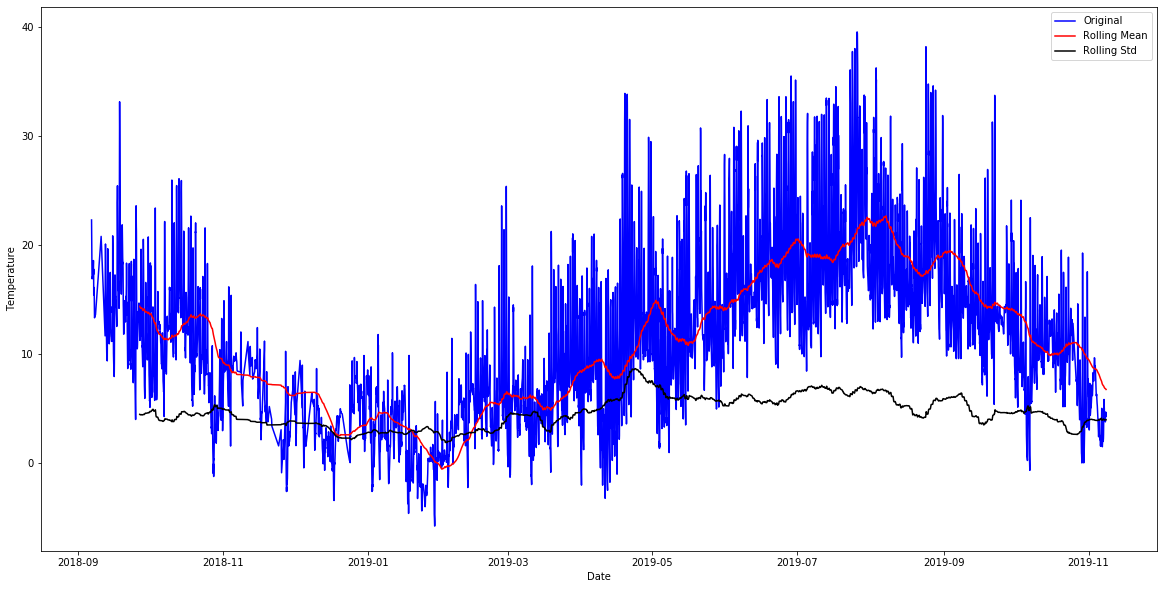

In [48]:
import numpy as np

def plot_std_rollmean(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365,center=False).mean() #window can be 12 <=> months, 365 <=> days, 52 <=> weeks
    rolstd = timeseries.rolling(window=365,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries.index, timeseries, color='blue',label='Original')
    mean = plt.plot(timeseries.index, rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries.index, rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc="best")
    plt.xlabel('Date')
    plt.ylabel('Temperature')

plot_std_rollmean(CSR)

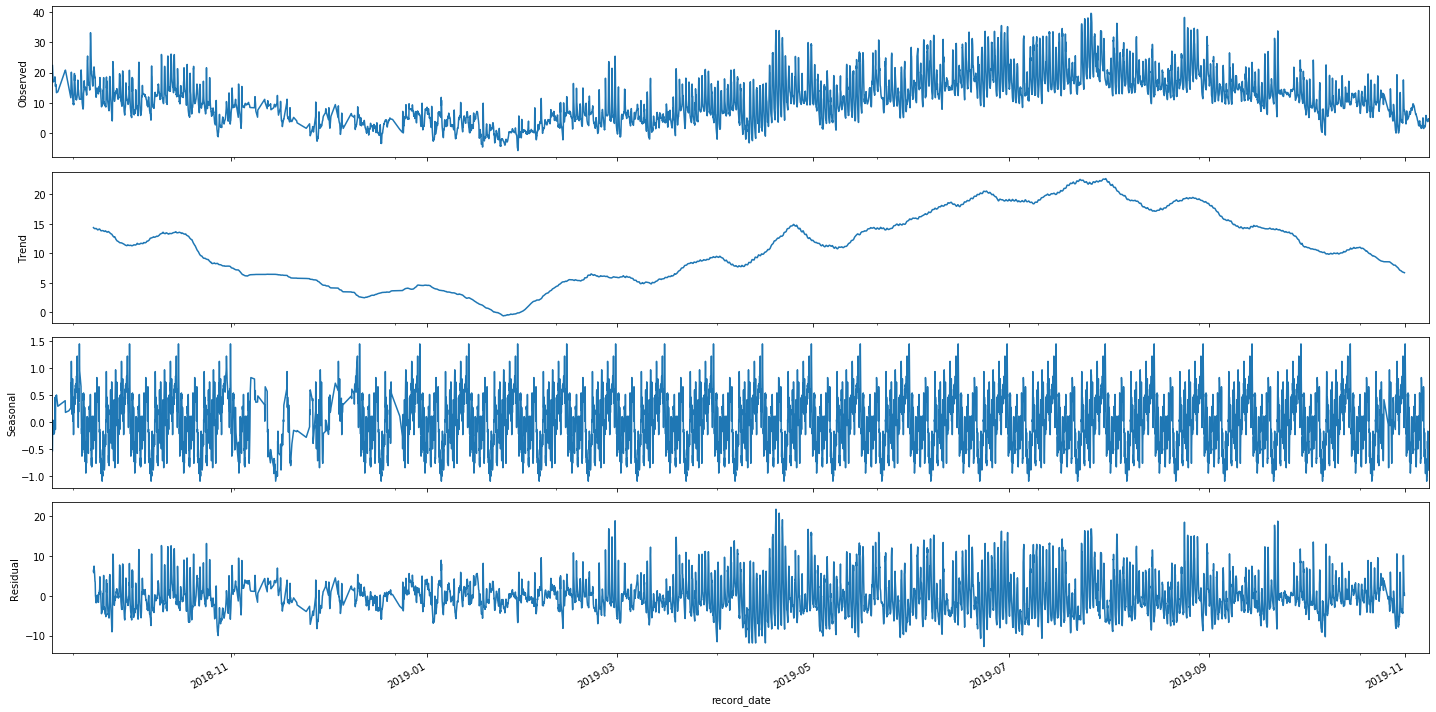

In [59]:
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

decomposition = sm.tsa.seasonal_decompose(CSR.interpolate(), model='additive', freq=365) #365 one year
fig = decomposition.plot()
plt.show()

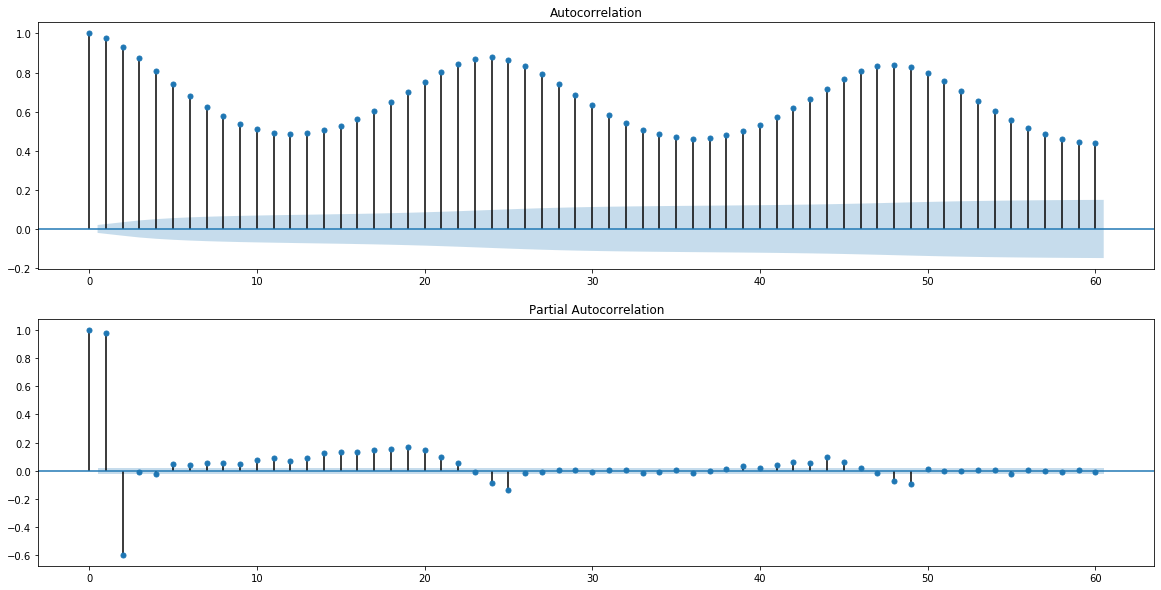

In [52]:
#Different plotting for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure(figsize=(20,10))
pyplot.subplot(211)
plot_acf(CSR, ax=pyplot.gca(), lags = 60) 
pyplot.subplot(212)
plot_pacf(CSR, ax=pyplot.gca(), lags = 60)
pyplot.show()

Applying differencing

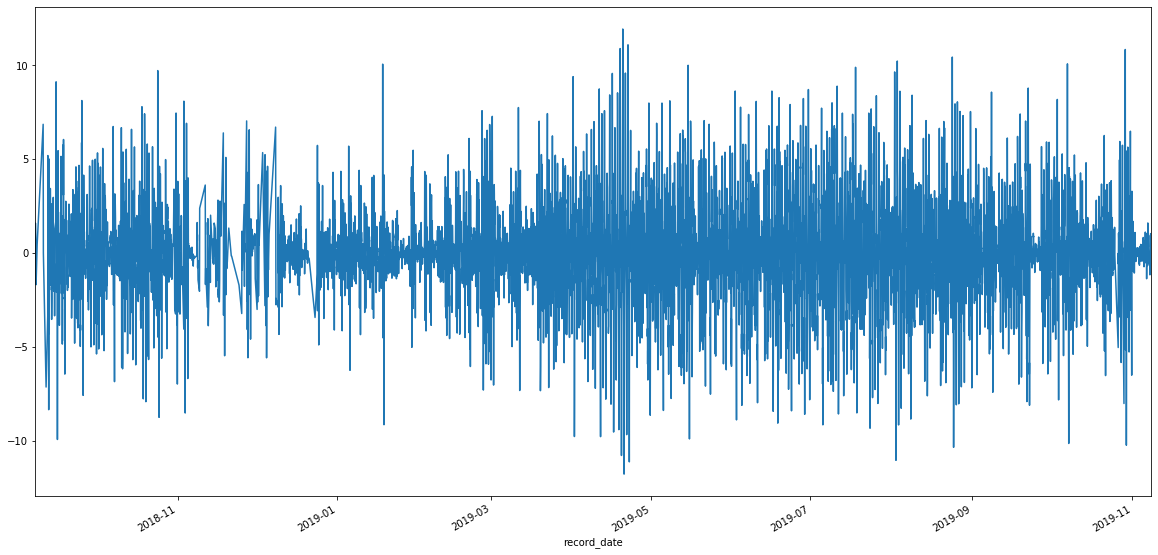

In [53]:
from statsmodels.tsa.statespace.tools import diff

CSR1 = diff(CSR,1,1,12).dropna() #first differencing, seasonal differencing
CSR1.plot(figsize=(20,10))

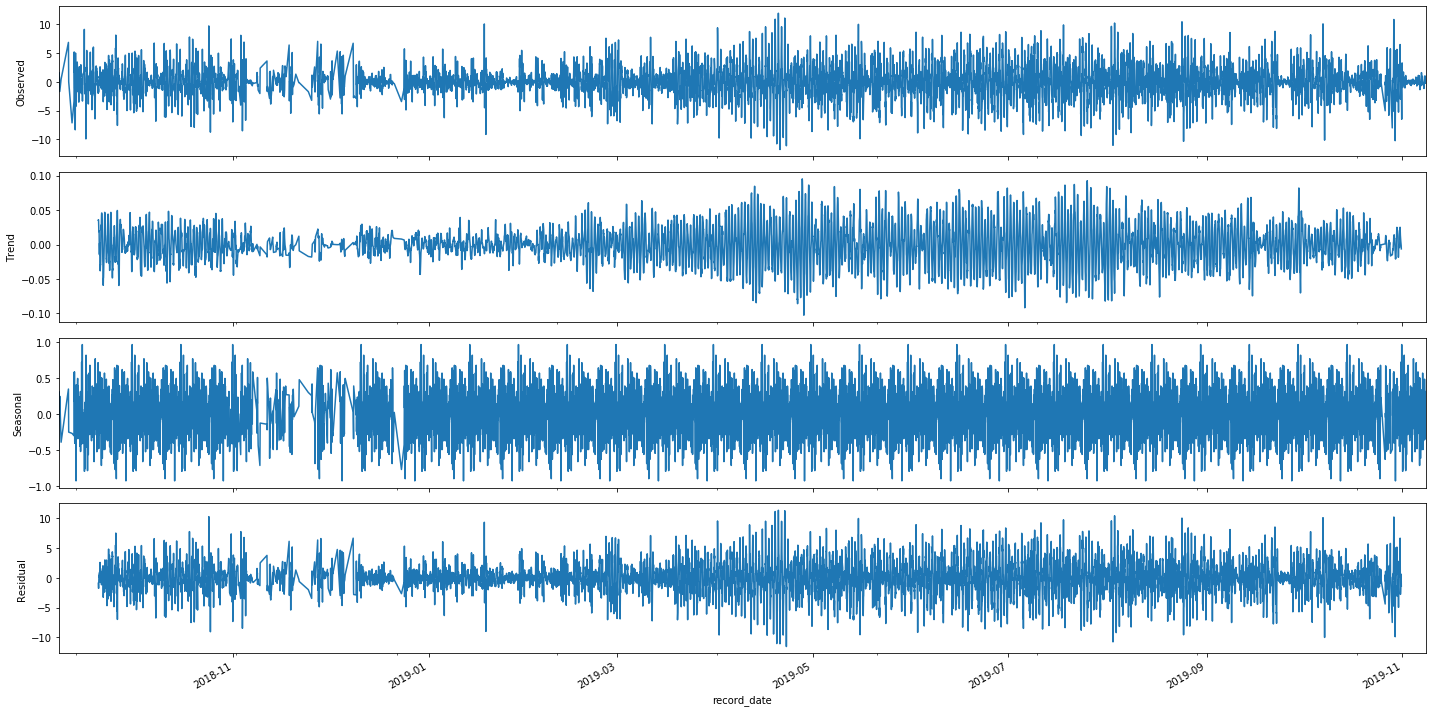

In [58]:
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

decomposition = sm.tsa.seasonal_decompose(CSR1.interpolate(), model='additive', freq=365)
fig = decomposition.plot()
plt.show()

Rerun the stationarity tests

In [23]:
test_stationarity(CSR1)

Results of Dickey-Fuller Test:
Test Statistic                  -29.302117
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9337.000000
Critical Value (1%)              -3.431051
Critical Value (5%)              -2.861850
Critical Value (10%)             -2.566935
dtype: float64


In [24]:
kpss_test(CSR1)

KPSS Statistic: 0.0014896243453746893
p-value: 0.1
num lags: 38
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



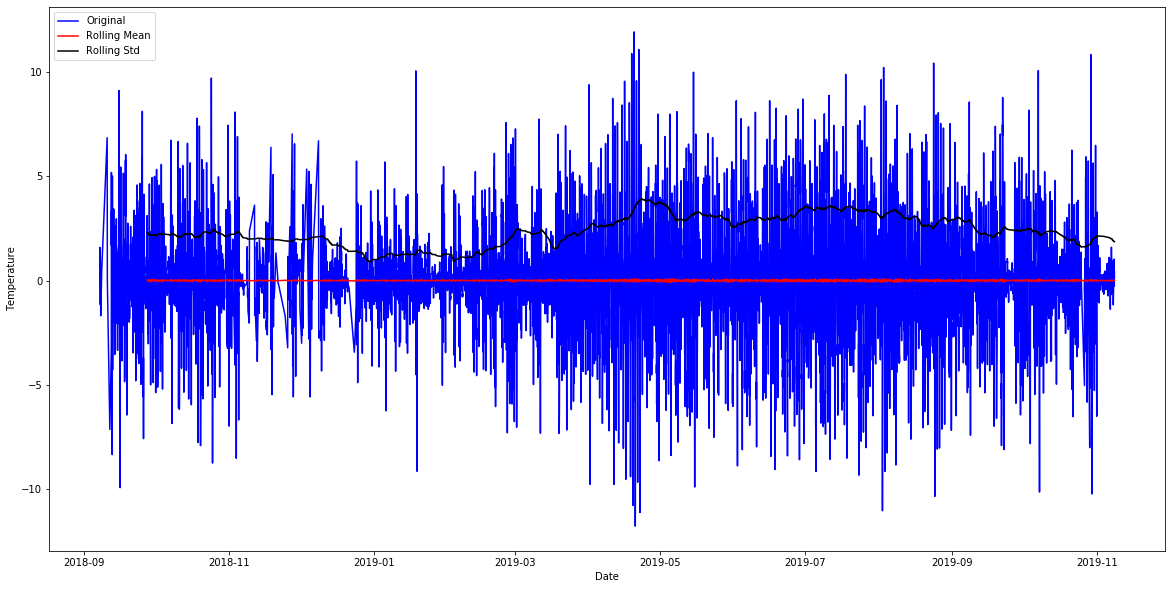

In [22]:
import numpy as np

plot_std_rollmean(CSR1)

# ACF and PACF

In [ ]:
#Different plotting for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure(figsize=(20,10))
pyplot.subplot(211)
plot_acf(CSR1, ax=pyplot.gca(), lags = 60) #why lags 30 ?
pyplot.subplot(212)
plot_pacf(CSR1, ax=pyplot.gca(), lags = 60)
pyplot.show()

# Splitting data into training and testing 

In [ ]:
train = CSR1['2018-09-06': '2019-09-06']
test = CSR1['2019-09-06': '2019-11-30']

#Plotting 
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name='Train', line_color='blue'))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='Test', line_color='green'))
fig.show()  

# SARIMAX

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(24, 1, 0),
                                trend="n",
                                #seasonal_order=(1, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
results.summary()

In [ ]:
results.plot_diagnostics(figsize=(20,10))
plt.show()

# ARIMA WITH MANUAL PARAMS

In [ ]:
train2 = CSR1[1: len(train)+360] #360 => 15 days
len(train2) 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train2, order=(24, 1, 0))

In [ ]:
fitted = model.fit()
# 2019-09-13
fitted.plot_predict(len(train2)-24, len(train2)+24) # 29 sept - 13:00
fitted.summary()

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train2, trend='n', order=(24,1,0), seasonal_order=(1,1,1,24))
results = mod.fit()
results.summary()

In [ ]:
import plotly.graph_objects as go

def plotarima(n_periods, timeseries, fitted):
    
    # Forecast
    # The alpha argument on the forecast() function specifies the prediction level
    # It is set by default to alpha=0.05, which is a 95% prediction interval. 
    # This is a sensible and widely used prediction interval.
    fc, se, conf = fitted.forecast(n_periods, alpha=0.05)  

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    
    # Create plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                        x=timeseries.index, 
                        y=timeseries.values,
                        mode='lines',
                        name='Training data'))
    fig.add_trace(go.Scatter(
                        x=fc_series.index,
                        y=fc_series.values,
                        mode='lines', 
                        name="Predicted curve"))
    fig.add_trace(go.Scatter(
                        x=test.index,
                        y=test.values,
                        mode='lines', 
                        name="Test data"))
    fig.add_trace(go.Scatter(
                        x=lower_series.index,
                        y=lower_series.values,
                        showlegend=False,
                        line_color='yellow'))
    fig.add_trace(go.Scatter(
                        x=upper_series.index,
                        y=upper_series.values,
                        fill='tonexty', 
                        mode='lines', 
                        name="95% Confidence interval",
                        line_color='yellow'))
    fig.update_layout(
            title={
                'text': "Manual ARIMA Model",
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
            xaxis_title="Record date",
            yaxis_title="Temperature",
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#7f7f7f"
                )
        )
    
    fig.show()
    
plotarima(1475, train2, fitted)
#fitted.summary()


# AUTO ARIMA

In [ ]:
import pmdarima as pm

def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [ ]:
import plotly.graph_objects as go

def plotarima(n_periods, timeseries, automodel):
    
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, return_conf_int=True)
    
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], periods=n_periods, freq="H")
    
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    
    # Upper and lower confidence bounds - confidence interval
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    
    # Create plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                        x=timeseries.index, 
                        y=timeseries.values,
                        mode='lines',
                        name='Training data'))
    fig.add_trace(go.Scatter(
                        x=fc_series.index,
                        y=fc_series.values,
                        mode='lines', 
                        name="Predicted curve"))
    fig.add_trace(go.Scatter(
                        x=test.index,
                        y=test.values,
                        mode='lines', 
                        name="Test data"))
    fig.add_trace(go.Scatter(
                        x=lower_series.index,
                        y=lower_series.values,
                        showlegend=False,
                        line_color='gray'))
    fig.add_trace(go.Scatter(
                        x=upper_series.index,
                        y=upper_series.values,
                        fill='tonexty', 
                        mode='lines', 
                        name="95% Confidence interval",
                        line_color='grey'))
    fig.update_layout(title={
                            'text': "ARIMA Model",
                            'y':0.9,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                        xaxis_title="Record date",
                        yaxis_title="Temperature",
                        font=dict(
                                family="Courier New, monospace",
                                size=12,
                                color="#7f7f7f"
                                ))
    
    fig.show()    

automodel = arimamodel(train)
plotarima(320, train, automodel)
automodel.summary()

# Diagnostics and Performance metrics

In [ ]:
automodel.plot_diagnostics(figsize=(20,10))
plt.show()

In [ ]:

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(train.values, test.values)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# rolling forcast
def run_rolling_forecasting(series, training_percentage):
    X = series.values
    train_size = int(len(X) * training_percentage)
    train, test = X[:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print("%d/%d predicted=%f, expected=%f" % (t, len(test), yhat, obs))
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)

    return test, predictions, mse, mae

test, predictions, mse, mae = \
    run_rolling_forecasting(series, training_percentage=.7)
print("Test MAE: %.3f; MSE: %.3f" % (mae, mse))
# plot
pyplot.plot(test)
pyplot.plot(predictions, color="red")
pyplot.show()

In [ ]:
import plotly.graph_objects as go
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(12, 1, 0))
#fitted = model.fit(disp=False)

#plot.figure(figsize=(20,10))
fig, ax = plt.subplots()
ax = CSR.loc['' : '2019-09-13'].plot(ax=ax)
fitted.plot_predict(60, 90, dynamic=True, ax=ax,plot_insample=False)

fitted.summary()

# Diagnostics and Performance metrics

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(train.values, test.values)